# Data Exploration

## Default imports

In [53]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import sklearn
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

## Video Image Split

In [2]:
!ls ./example_dataset/images

VIRAT_S_000002_fr_0.2


In [55]:
def filter_file_extension(filename):
    
    file_extension = 'mp4'
    
    if file_extension in filename:
        return True
    else:
        return False

def get_videos_from_folder(path):
    
    all_items = os.listdir(path)
    only_videos = [video_name for video_name in filter(filter_file_extension, all_items)]
    video_filenames = [video_name.split('.')[0] for video_name in only_videos]
    videos_file_paths = [os.path.join(path, video_fp) for video_fp in only_videos]
    
    return videos_file_paths, video_filenames

In [57]:
video_file_paths, video_filenames = get_videos_from_folder('./poc_dataset/')

In [58]:
def get_frame(sec, video_object):
    '''
        Based on the given sec, extract the resulting image from the video_object.
    '''
    video_object.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    success, image = video_object.read()
    return success, image
    

def write_images_from_video(video_path, video_filename, frame_rate):
    '''
        Splits the video by the frame_rate, shown in the video_path variable into different frames,
        then writes the resulting images in a folder with the  video's filename.
        Creates the folder if it exits.
    
    '''
    video_object = cv2.VideoCapture(video_path)
    sec = 0
    count = 0
    frame_rate = 1 / frame_rate # looking at the actual time from second to the next
    success = 1
    
    while success:
        
        success, image = get_frame(sec, video_object)
        
        # create the folder if not exists
        video_file_name = f'{video_filename}_fr_{frame_rate}'
        folder_path = f'./poc_dataset/images/{video_file_name}'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        # write the image
        cv2.imwrite(os.path.join(folder_path, f'{video_filename}_frame_{np.round(count,2)}.jpg'), image)
        
        sec = sec + frame_rate
        count += 1
    
    print(f'File {video_filename} processed.')

In [59]:
write_images_from_video(video_file_paths[0], video_filenames[0], 0.5)

File VIRAT_S_000002 processed.


## Utils
Various helper functions that are used in general.

In [7]:
def load_csv_datasets(path):
    files = os.listdir(path)
    
    data = {}
    for file in files:
        filename = file.split('.')[0]
        filepath = os.path.join(path, file)
        data[filename] = pd.read_csv(filepath)
    
    return data

## People Counting with Object Recognition Methods

[Reference](https://machinelearningmastery.com/object-recognition-with-deep-learning/?fbclid=IwAR3QHzwV3iteB2tE7EJo3GkNTT_v7loLqHtCqYuH5nopySIkzvTmHiUa-H0)

### 1. Faster R-CNN
* [Reference of Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf)  
* [Reference of implementation](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)
* [Reference Jupyter Notebook for the implementation](https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras/blob/master/frcnn_train_vgg.ipynb)

#### 1.1 Getting The Data:

#### 1.1.1 Downloading the dataset information with the corresponding bounding boxes

In [7]:
!wget https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-annotations-bbox.csv && \
!wget https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv

--2019-11-26 21:53:32--  https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-annotations-bbox.csv
Resolving datasets.figure-eight.com (datasets.figure-eight.com)... 52.200.149.96, 3.227.119.162, 3.227.227.96
Connecting to datasets.figure-eight.com (datasets.figure-eight.com)|52.200.149.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1,1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1,11G   448KB/s    in 72m 55s 

2019-11-26 23:06:28 (267 KB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]



In [11]:
datasets = load_csv_datasets('./training_dataset/')

In [20]:
list(datasets.keys())

['train-images-boxable',
 'train-annotations-bbox',
 'class-descriptions-boxable']

#### 1.1.2 Downloading the actual dataset

In [73]:
cldesc_df = datasets['class-descriptions-boxable']
cldesc_df.columns = ['label_id', 'class']
# get the Label Name that I need - person
label_id = cldesc_df.loc[cldesc_df['class'] == 'Person', 'label_id'].values[0]

In [57]:
trannbb_df = datasets['train-annotations-bbox']
trimb_df = datasets['train-images-boxable']

In [66]:
# Creating an image id from the name
trimb_df['ImageID'] = trimb_df['image_name'].apply(lambda x: x.split('.')[0])
trimb_df.head()

,image_name,image_url,ImageID
0,e39871fd9fd74f55.jpg,https://requestor-proxy.figure-eight.com/figur...,e39871fd9fd74f55
1,f18b91585c4d3f3e.jpg,https://requestor-proxy.figure-eight.com/figur...,f18b91585c4d3f3e
2,ede6e66b2fb59aab.jpg,https://requestor-proxy.figure-eight.com/figur...,ede6e66b2fb59aab
3,ed600d57fcee4f94.jpg,https://requestor-proxy.figure-eight.com/figur...,ed600d57fcee4f94
4,ff47e649b23f446d.jpg,https://requestor-proxy.figure-eight.com/figur...,ff47e649b23f446d


In [89]:
num_images = 100000
person_bb_df = trannbb_df[trannbb_df['LabelName'] == label_id] # getting a filtered dataset of only images that contain persons
image_ids = list(trannbb_df.loc[trannbb_df['LabelName'] == label_id, 'ImageID'].unique())[:num_images] # get a list with the image ids

In [93]:
# filtered df based on the image ids
filtered_trimb_df = trimb_df[trimb_df['ImageID'].isin(image_ids)]

In [107]:
def pull_write_img(url, filename, path):
    r = requests.get(url)
    filepath = os.path.join(path, filename + '.jpg')
    if r.status_code == 200:
        with open(filepath, 'wb') as w:
            w.write(r.content)
            
def download_images(df, path):
    # hardcoding column names is not a good idea... 
    for imid, url in zip(df['ImageID'].values, df['image_url'].values):
        pull_write_img(url, imid, path)
    
    print('Done!')

In [108]:
download_images(filtered_trimb_df, './training_dataset/images')

Done!


#### 1.1.3 Implemented Faster RCNN
Faster RCNN is the third itteration of the RCNN implementation, with the advantage of being faster. This is due to implementing a RPN (region proposal network) instead of using SS (selective search). More details can be found in the following papers:
* [Rich feature hierarchies for accurate object detection and semantic segmentation](https://arxiv.org/abs/1311.2524)
* [Fast R-CNN](https://arxiv.org/abs/1504.08083)
* [Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks](https://arxiv.org/abs/1506.01497)

### 2. YOLO
The YOLO (You Only Look Once) Algorithm for Object Detection. You can find more details by reading the paper:
* [YOLOv3: An Incremental Improvement](https://pjreddie.com/media/files/papers/YOLOv3.pdf).  
For the purpose of the PoC a pretrained model will be used, or more specificaly [keras-yolo3](https://github.com/experiencor/keras-yolo3). 

#### 2.1 Cloning the repo and downloading the pretrained model weights.

In [ ]:
# clone the keras-yolo3
!git clone https://github.com/experiencor/keras-yolo3.git ./yolo3

In [111]:
# get the model weights
!wget -P ./yolo3/weights/ https://pjreddie.com/media/files/yolov3.weights

--2019-11-30 19:14:55--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘./yolo3/weights/yolov3.weights’

yolov3.weights      100%[===================>] 236,52M   810KB/s    in 7m 5s   

2019-11-30 19:22:01 (569 KB/s) - ‘./yolo3/weights/yolov3.weights’ saved [248007048/248007048]



#### 2.2 Loading the pretrained model

In [2]:
# importing the module
from yolo3.yolo3_one_file_to_detect_them_all import *

Using TensorFlow backend.


In [3]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('./yolo3/weights/yolov3.weights')
# set the model wieghts into the model
weight_reader.load_weights(model)
# save the model to file
model.save('./yolo3/weights/model.h5')













loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of con

#### 2.3 Making a prediction

In [3]:
# helper imports
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array

In [8]:
def load_image_pixes(filename, shape):
    img_tmp = load_img(filename)
    width, height = img_tmp.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)

    return image, width, height

In [49]:
# helper functions
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    plt.subplots(figsize=(15, 10))
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white')
    
    # show the plot
    plt.show()

In [71]:
# load the model
model = load_model('yolo3/weights/model.h5')
input_w, input_h = 416, 416
image_filepath = './poc_dataset/images/VIRAT_S_000002_fr_2.0/VIRAT_S_000002_frame_92.jpg'
image, image_w, image_h = load_image_pixes(image_filepath, (input_w, input_h))
yhat = model.predict(image)
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [72]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, 0.5,input_h, input_w)

In [73]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)

person 96.74121737480164
person 94.32909488677979
person 95.21982073783875
person 99.60480332374573


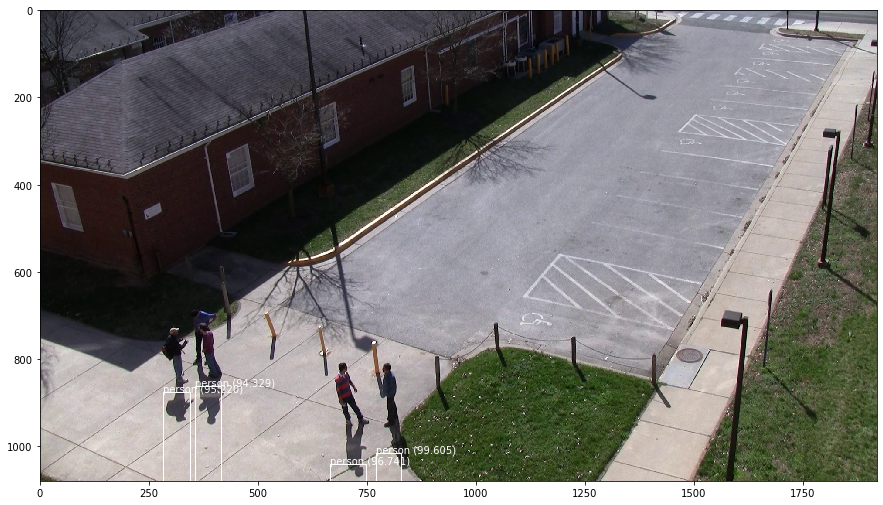

In [74]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(image_filepath, v_boxes, v_labels, v_scores)